@ author: Gediyon M. Girma
CartPole-V0 control problem solved with MonteCarlo method

In [9]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1

In [10]:
%pip install gym pyvirtualdisplay > /dev/null 2>&1

In [11]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

In [12]:
!apt-get install -y xvfb

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.10).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [13]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

Iterations that were run: 32


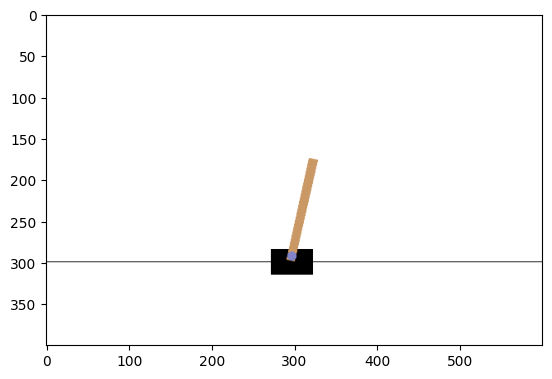

In [15]:
env = gym.make("CartPole-v0")
env.reset()
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

for i in range(50000):
  action = env.action_space.sample()
  print("step i",i,"action=",action)
  obs, reward, done, info = env.step(action)
  print("obs=",obs,"reward=",reward,"done=",done,"info=",info)
  screen = env.render(mode='rgb_array')

  plt.imshow(screen)
  ipythondisplay.clear_output(wait=True)
  ipythondisplay.display(plt.gcf())

  if done:
    break

ipythondisplay.clear_output(wait=True)
env.close()
print("Iterations that were run:",i)

In [16]:
# part 1: initialization
import time
import itertools
import random

# discritizing function for the observation space

def discretize(value,min_value,max_value,num_bins):
  """
  Discretizes a value using a uniform grid, clamping values outside of the grid range.

  Args:
    value: The value to discretize.
    min_value: The minimum value of the grid.
    max_value: The maximum value of the grid.
    num_bins: The number of bins to use.

  Returns:
    The discretized value.
  """
  value = min(max(value, min_value), max_value)


  bin_size = (max_value - min_value) / num_bins
  bin_index = int((value - min_value) / bin_size)

  return bin_index


def discretize_observation(observation):
  """
  Discretizes the observation space.

  Args:
    observation: The observation to discretize.

  Returns:
    The discretized observation.
  """


  cart_position, cart_velocity, pole_angle, pole_velocity = observation

  state = [discretize(cart_position, -4.8, 4.8, 9),
           discretize(cart_velocity, -5, 5, 9),
           discretize(pole_angle, -0.418, 0.418, 9),
           discretize(pole_velocity, -5, 5, 9)
           ]
  return tuple(state)


# initializing the action-value function


# defining the number of bins and therefore the vlaues of the the observation space
cart_position_bins = 10
cart_velocity_bins = 10
pole_angle_bins = 10
pole_velocity_bins = 10

# formaulate the state space with every combination of the discritsized elements of the states
states = itertools.product([x for x in range(cart_position_bins)],
                                [x for x in range(cart_velocity_bins)],
                                [x for x in range(pole_angle_bins)],
                                [x for x in range(pole_velocity_bins)])

# initialize the action-value function
q = {}
c = {}
policy = {}
b = {} # behaviour policy

for state in states:
  c[state] = np.zeros((env.action_space.n)) # initialize the sum for the s-a pair
  b[state] = np.full(((env.action_space.n)),1/env.action_space.n) # initialize the behaviour policy
  q[state] = np.random.random((env.action_space.n)) # initialize the action-value function
  policy[state] = np.zeros((env.action_space.n)) # setting zero probabilities for all actions

  best_action = np.argmax(q[state])  # selecting the best action based on the action-value function
  policy[state][best_action] = 1  # setting 1 to the probability of the best action



In [37]:
# part 2 - Iteration

start_timer = time.time() # starting the timer


epsilon = 0.1

episodes = 1e5
episode = 1
while episode < episodes:

  # reset the environment
  obs = env.reset()
  state = discretize_observation(obs) # discretize the observation

  # initializing a dictionary to save the episode's trajectory
  episode_trajectory = [[0, state]] # starting reward (0) and state

  # generating an episodes using a an epsilon greedy policy
  for t in range(1,50000):

    # selecting action for the episode based on b (e-soft policy version of our target policy)
    rnd_num = np.random.uniform(0,1) # generating a random number
    cumlative_action_prob = np.cumsum(b[state])  # cumlative action probabilities
    action = np.argmax(cumlative_action_prob > rnd_num) # selecting the action based on the random number

    episode_trajectory[-1].append(action) # appending the action to the episode trajectory

    obs, reward, done, info = env.step(action)
    state = discretize_observation(obs) # discretize the observation
    episode_trajectory.append([reward,state]) # append the reward and the state to the episode trajectory

    if done:
      break


  # initializing the return and the weight
  G = 0
  W = 1
  gamma = 0.9 # discount factor

  # updating the action-value function
  for t in range(len(episode_trajectory)-2,-1,-1):
    G = gamma*G  + episode_trajectory[t+1][0]
    state = episode_trajectory[t][1]
    action = episode_trajectory[t][2]
    c[state][action] += W  # updating the sum for the s-a pair
    q[state][action] += (W/c[state][action]) * (G - q[state][action]) # incremental averaging

    best_action = np.argmax(q[state]) # selecting the best action based on the action-value function

    policy[state] = np.zeros(env.action_space.n) # resetting the policy for the given state
    policy[state][best_action] = 1 # setting the probability of the best action to 1


    if action != best_action:
      break
    W = W/b[state][action]


  for state in states:
    best_action = np.argmax(q[state])
    b[state] = np.full(((env.action_space.n)),epsilon/env.action_space.n)
    b[state][best_action] += (1-epsilon)


  episode += 1
  if episode % 10000 == 0:
    end_timer = time.time()
    timer = end_timer - start_timer
    elapsed_time_struct = time.gmtime(timer)
    formatted_time = time.strftime("%H:%M:%S", elapsed_time_struct)
    print("Episode: ",episode, " time: ", formatted_time)

  if episode == episodes:
    print("done!")

Episode:  10000  time:  00:02:31
Episode:  20000  time:  00:05:03
Episode:  30000  time:  00:07:34
Episode:  40000  time:  00:10:05
Episode:  50000  time:  00:12:36
Episode:  60000  time:  00:15:08
Episode:  70000  time:  00:17:38
Episode:  80000  time:  00:20:10
Episode:  90000  time:  00:22:41
Episode:  100000  time:  00:25:12
done!


In [41]:

obs = env.reset()
state = discretize_observation(obs)
# prev_screen = env.render(mode='rgb_array')
# plt.imshow(prev_screen)
reward = 0
for i in range(50000):
  action = np.argmax(policy[state])
  print("step",i, "reward: ", reward," state: ", state," action=",action)
  obs, reward, done, info = env.step(action)
  # print("obs=",obs,"reward=",reward,"done=",done,"info=",info)
  state = discretize_observation(obs)
  # screen = env.render(mode='rgb_array')

  # plt.imshow(screen)
  # ipythondisplay.clear_output(wait=True)
  # ipythondisplay.display(plt.gcf())

  if done:
    print ("done")
    break

# ipythondisplay.clear_output(wait=True)
env.close()
print("Iterations that were run:",i)

step 0 reward:  0  state:  (4, 4, 4, 4)  action= 1
step 1 reward:  1.0  state:  (4, 4, 4, 4)  action= 1
step 2 reward:  1.0  state:  (4, 4, 4, 3)  action= 0
step 3 reward:  1.0  state:  (4, 4, 4, 4)  action= 1
step 4 reward:  1.0  state:  (4, 4, 4, 4)  action= 1
step 5 reward:  1.0  state:  (4, 5, 4, 3)  action= 0
step 6 reward:  1.0  state:  (4, 4, 4, 4)  action= 1
step 7 reward:  1.0  state:  (4, 5, 4, 3)  action= 0
step 8 reward:  1.0  state:  (4, 4, 3, 3)  action= 0
step 9 reward:  1.0  state:  (4, 4, 3, 4)  action= 1
step 10 reward:  1.0  state:  (4, 4, 3, 3)  action= 0
step 11 reward:  1.0  state:  (4, 4, 3, 4)  action= 1
step 12 reward:  1.0  state:  (4, 4, 3, 3)  action= 0
step 13 reward:  1.0  state:  (4, 4, 3, 4)  action= 1
step 14 reward:  1.0  state:  (4, 4, 3, 3)  action= 0
step 15 reward:  1.0  state:  (4, 4, 3, 4)  action= 1
step 16 reward:  1.0  state:  (4, 4, 3, 3)  action= 0
step 17 reward:  1.0  state:  (4, 4, 2, 4)  action= 0
step 18 reward:  1.0  state:  (4, 4, 2, 